# 02_Gradient-Based

In [1]:
import os
import cv2
import math
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
model = VGG16()
model.summary()

2022-04-29 15:20:00.648499: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-04-29 15:20:00.649223: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-04-29 15:20:00.649538: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with th

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [3]:
def load_imagenet_labels(labels_file):
    with open(labels_file) as reader:
        f = reader.read()
        labels = f.splitlines()
    return np.array(labels)

imagenet_labels = load_imagenet_labels('data/ImageNetLabels.txt')

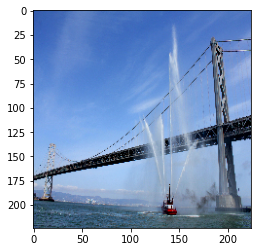

In [4]:
def read_image(img_path):
    image = tf.io.read_file(img_path)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, size=(224, 224))
#     image = tf.image.resize_with_pad(image, target_height=224, target_width=224)
    return image

image = read_image('data/fireboat.jpg')
plt.imshow(image/255)

In [5]:
def top_k_predictions(img, k=3):
    image_batch = tf.expand_dims(img, 0)
    inputs = preprocess_input(image_batch)
    predictions = model(inputs)
    top_probs, top_idxs = tf.math.top_k(input=predictions, k=k)
    top_labels = imagenet_labels[tuple(top_idxs)]
    return top_labels, top_probs[0]

In [6]:
pred_label, pred_prob = top_k_predictions(image)
for label, prob in zip(pred_label, pred_prob):
    print(f'{label}: {prob:0.1%}')

fireboat: 98.6%
drilling platform: 0.3%
crane: 0.2%


In [7]:
def compute_gradients(images, target_class_idx):
    with tf.GradientTape() as tape:
        tape.watch(images)
        logits = model(images)
        probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
    return tape.gradient(probs, images)

## [1. Sensitivity Analysis (Simonyan et al. 14)](https://arxiv.org/abs/1312.6034)

In [8]:
image_batch = tf.expand_dims(image, 0)
inputs = preprocess_input(image_batch)
gradients = compute_gradients(
    images=inputs,
    target_class_idx=554)

attribution_mask = tf.reduce_sum(tf.math.abs(tf.squeeze(gradients)), axis=-1)

In [9]:
@tf.function
def vanilla_gradients(image,
                      target_class_idx):
    image_batch = tf.expand_dims(image, 0)
    inputs = preprocess_input(image_batch)
    gradients = compute_gradients(
        images=inputs,
        target_class_idx=target_class_idx)

    return tf.squeeze(gradients)

In [10]:
vg_attributions = vanilla_gradients(image=image,
                                    target_class_idx=554)

attribution_mask = tf.reduce_sum(tf.math.abs(vg_attributions), axis=-1)

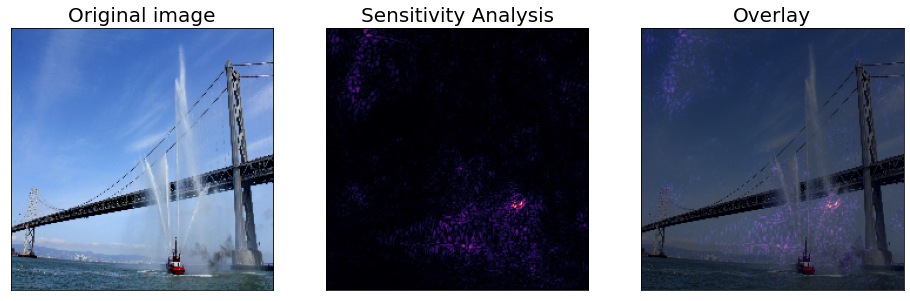

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=3, squeeze=False, figsize=(16, 8),
                        subplot_kw={'xticks':[], 'yticks':[]})

axs[0, 0].set_title('Original image', fontsize=20)
axs[0, 0].imshow(image/255)

axs[0, 1].set_title('Sensitivity Analysis', fontsize=20)
axs[0, 1].imshow(attribution_mask, cmap=cm.inferno)

axs[0, 2].set_title('Overlay', fontsize=20)
axs[0, 2].imshow(attribution_mask, cmap=cm.inferno)
axs[0, 2].imshow(image/255, alpha=0.4)

## [2. SmoothGrad (Smikov et al. 17)](https://arxiv.org/abs/1706.03825)

In [12]:
def generate_noisy_images(images, num_samples, noise):
    repeated_images = tf.repeat(images, num_samples, axis=0)
    noise = np.random.normal(0, noise, repeated_images.shape).astype(np.float32)
    return tf.clip_by_value(repeated_images + noise, 0, 255)

In [13]:
num_samples = 10
noise = 10
image_batch = tf.expand_dims(image, 0)
noisy_images = generate_noisy_images(image_batch, num_samples, noise)

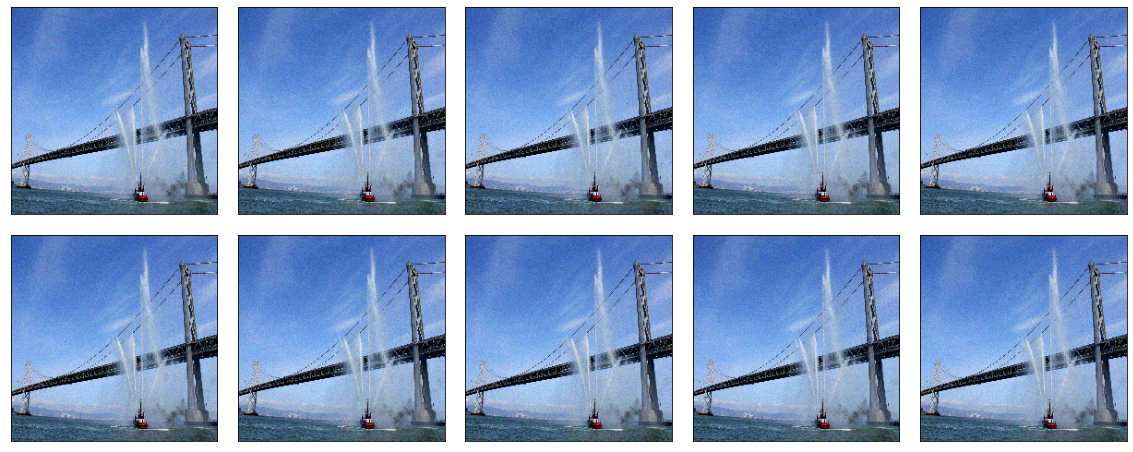

In [14]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20, 8),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(5):
    ax[0, i].imshow(noisy_images[i]/255)
    ax[1, i].imshow(noisy_images[i+5]/255)

In [15]:
inputs = preprocess_input(noisy_images)
gradients = compute_gradients(
    images=inputs,
    target_class_idx=554)

averaged_grads = tf.reduce_mean(gradients, axis=0)
attribution_mask = tf.reduce_sum(tf.math.abs(averaged_grads), axis=-1)

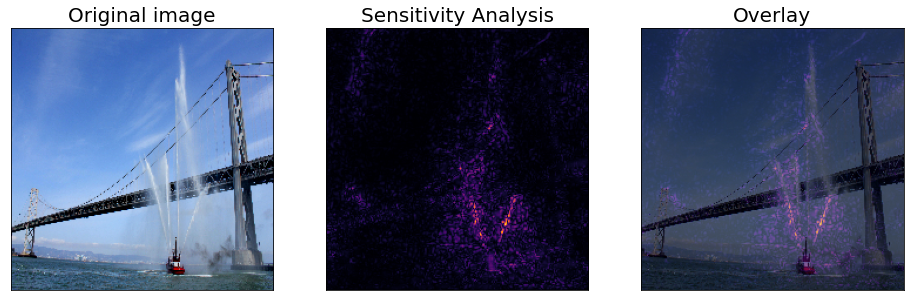

In [16]:
fig, axs = plt.subplots(nrows=1, ncols=3, squeeze=False, figsize=(16, 8),
                        subplot_kw={'xticks':[], 'yticks':[]})

axs[0, 0].set_title('Original image', fontsize=20)
axs[0, 0].imshow(image/255)

axs[0, 1].set_title('Sensitivity Analysis', fontsize=20)
axs[0, 1].imshow(attribution_mask, cmap=cm.inferno)

axs[0, 2].set_title('Overlay', fontsize=20)
axs[0, 2].imshow(attribution_mask, cmap=cm.inferno)
axs[0, 2].imshow(image/255, alpha=0.4)

In [17]:
@tf.function
def smooth_gradients(image,
                     target_class_idx,
                     num_samples,
                     noise=1):
    
    image_batch = tf.expand_dims(image, 0)
    noisy_images = generate_noisy_images(image_batch, num_samples, noise)
    inputs = preprocess_input(noisy_images)

    gradients = compute_gradients(
        images=inputs,
        target_class_idx=target_class_idx)

    averaged_grads = tf.reduce_mean(gradients, axis=0)

    return tf.squeeze(averaged_grads)

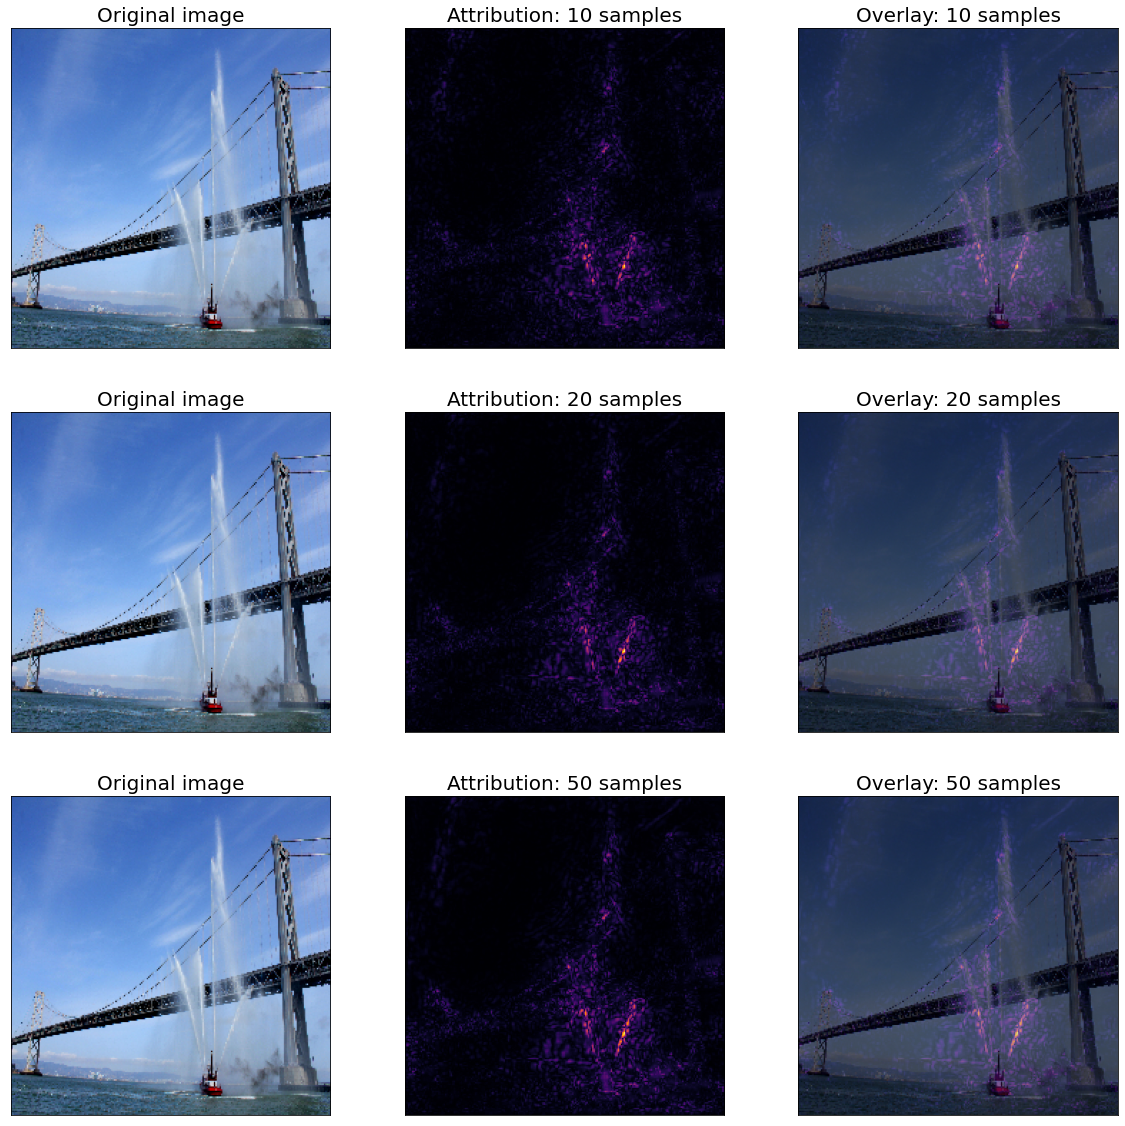

In [18]:
num_samples = [10, 20, 50] 

fig, axs = plt.subplots(nrows=3, ncols=3, squeeze=False, figsize=(20, 20),
                        subplot_kw={'xticks':[], 'yticks':[]})

for i, num_sample in enumerate(num_samples):
    
    axs[i, 0].set_title('Original image', fontsize=20)
    axs[i, 0].imshow(image/255)
    
    averaged_grads = smooth_gradients(image, 554, num_sample, noise=10)
    attribution_mask = tf.reduce_sum(tf.math.abs(averaged_grads), axis=-1)
    
    axs[i, 1].set_title(f'Attribution: {num_sample} samples', fontsize=20)
    axs[i, 1].imshow(attribution_mask, cmap=cm.inferno)

    axs[i, 2].set_title(f'Overlay: {num_sample} samples', fontsize=20)
    axs[i, 2].imshow(attribution_mask, cmap=cm.inferno)
    axs[i, 2].imshow(image/255, alpha=0.4)

## [3. Integrated Gradients (Sundararajan et al. 17)](https://arxiv.org/abs/1703.01365)

In [19]:
def f(x):
  """A simplified model function."""
  return tf.where(x < 0.8, x, 0.8)

def interpolated_path(x):
  """A straight line path."""
  return tf.zeros_like(x)

x = tf.linspace(start=0.0, stop=1.0, num=6)
y = f(x)

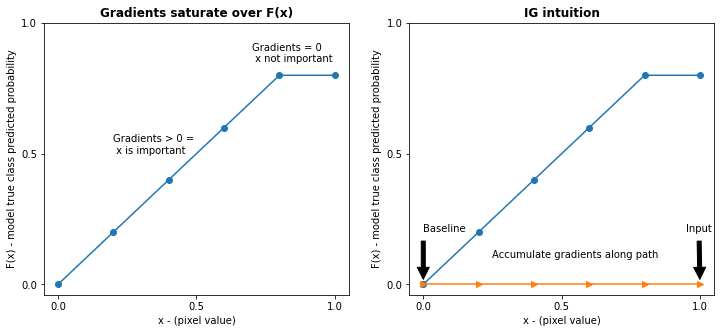

In [20]:
fig = plt.figure(figsize=(12, 5))
ax0 = fig.add_subplot(121)
ax0.plot(x, f(x), marker='o')
ax0.set_title('Gradients saturate over F(x)', fontweight='bold')
ax0.text(0.2, 0.5, 'Gradients > 0 = \n x is important')
ax0.text(0.7, 0.85, 'Gradients = 0 \n x not important')
ax0.set_yticks(tf.range(0, 1.5, 0.5))
ax0.set_xticks(tf.range(0, 1.5, 0.5))
ax0.set_ylabel('F(x) - model true class predicted probability')
ax0.set_xlabel('x - (pixel value)')

ax1 = fig.add_subplot(122)
ax1.plot(x, f(x), marker='o')
ax1.plot(x, interpolated_path(x), marker='>')
ax1.set_title('IG intuition', fontweight='bold')
ax1.text(0.25, 0.1, 'Accumulate gradients along path')
ax1.set_ylabel('F(x) - model true class predicted probability')
ax1.set_xlabel('x - (pixel value)')
ax1.set_yticks(tf.range(0, 1.5, 0.5))
ax1.set_xticks(tf.range(0, 1.5, 0.5))
ax1.annotate('Baseline', xy=(0.0, 0.0), xytext=(0.0, 0.2),
             arrowprops=dict(facecolor='black', shrink=0.1))
ax1.annotate('Input', xy=(1.0, 0.0), xytext=(0.95, 0.2),
             arrowprops=dict(facecolor='black', shrink=0.1))
plt.show();

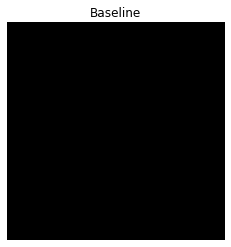

In [21]:
baseline = tf.zeros(shape=(224,224,3))

plt.imshow(baseline)
plt.title("Baseline")
plt.axis('off')
plt.show()

### Interpolate images

In [22]:
m_steps = 5
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1) # Generate m_steps intervals for integral_approximation() below.

In [23]:
def interpolate_images(baseline,
                       image,
                       alphas):
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    baseline_x = tf.expand_dims(baseline, axis=0)
    input_x = tf.expand_dims(image, axis=0)
    delta = input_x - baseline_x
    images = baseline_x + alphas_x * delta
    return images

In [24]:
interpolated_images = interpolate_images(
    baseline=baseline,
    image=image,
    alphas=alphas)

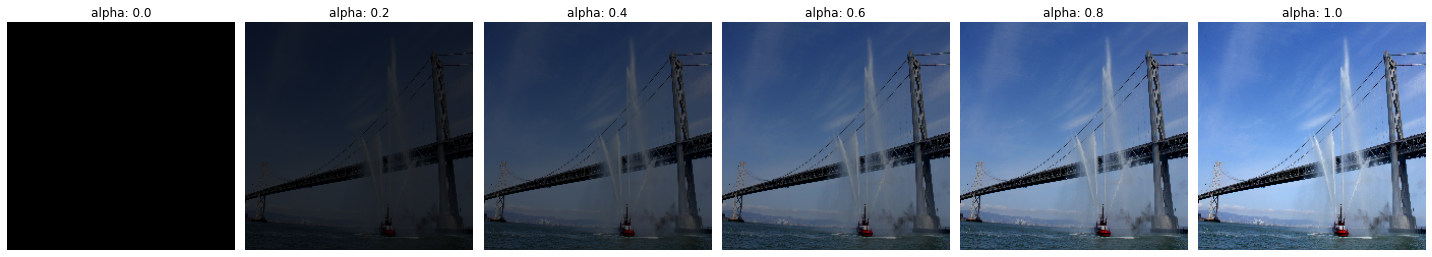

In [25]:
fig = plt.figure(figsize=(20, 20))

i = 0
for alpha, image in zip(alphas, interpolated_images):
    i += 1
    plt.subplot(1, len(alphas), i)
    plt.title(f'alpha: {alpha:.1f}')
    plt.imshow(image/255)
    plt.axis('off')

plt.tight_layout();

### Compute gradients

In [26]:
inputs = preprocess_input(interpolated_images)

path_gradients = compute_gradients(
    images=inputs,
    target_class_idx=554)

In [27]:
print(path_gradients.shape)

(6, 224, 224, 3)


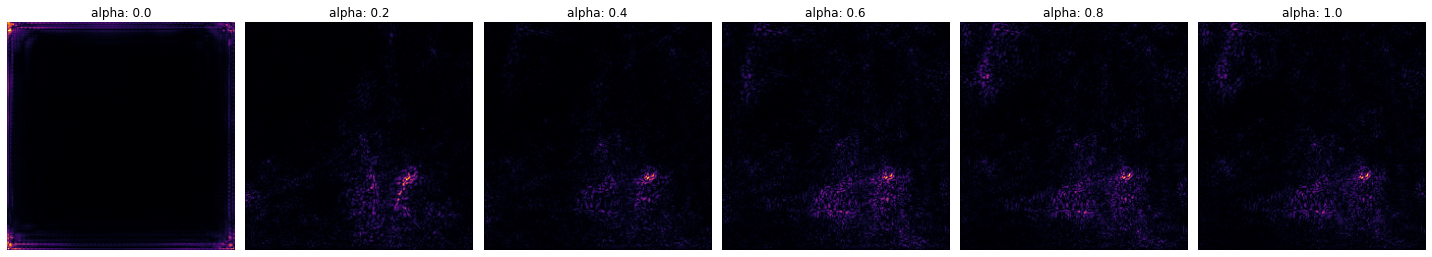

In [28]:
attribution_mask = tf.reduce_sum(tf.math.abs(path_gradients), axis=-1)

fig = plt.figure(figsize=(20, 20))

i = 0
for alpha, attribution in zip(alphas, attribution_mask):
    i += 1
    plt.subplot(1, len(alphas), i)
    plt.title(f'alpha: {alpha:.1f}')
    plt.imshow(attribution, cmap=cm.inferno)
    plt.axis('off')

plt.tight_layout();

### Visualizing gradient saturation

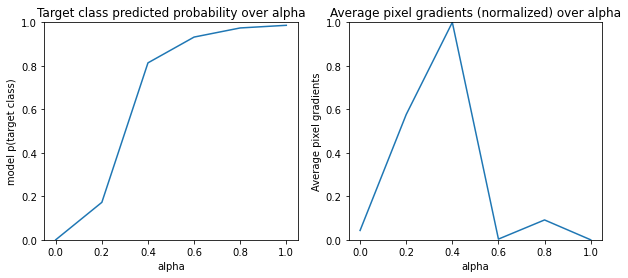

In [29]:
pred_proba = model(inputs)[:, 554]

plt.figure(figsize=(10, 4))
ax1 = plt.subplot(1, 2, 1)
ax1.plot(alphas, pred_proba)
ax1.set_title('Target class predicted probability over alpha')
ax1.set_ylabel('model p(target class)')
ax1.set_xlabel('alpha')
ax1.set_ylim([0, 1])

ax2 = plt.subplot(1, 2, 2)
# Average across interpolation steps
average_grads = tf.reduce_mean(path_gradients, axis=[1, 2, 3])
# Normalize gradients to 0 to 1 scale. E.g. (x - min(x))/(max(x)-min(x))
average_grads_norm = (average_grads-tf.math.reduce_min(average_grads))/(tf.math.reduce_max(average_grads)-tf.reduce_min(average_grads))
ax2.plot(alphas, average_grads_norm)
ax2.set_title('Average pixel gradients (normalized) over alpha')
ax2.set_ylabel('Average pixel gradients')
ax2.set_xlabel('alpha')
ax2.set_ylim([0, 1]);

### Accumulate gradients (integral approximation)
$IntegratedGrads^{approx}_{i}(x)::=(x_{i}-x'_{i})\times \overbrace{\sum_{k=1}^{m}}^\text{Sum m local gradients}
\text{gradients(interpolated images)} \times \overbrace{\frac{1}{m}}^\text{Divide by m steps}$

From the equation, you can see you are summing over `m` gradients and dividing by `m` steps. You can implement the two operations together for part 3 as an *average of the local gradients of `m` interpolated predictions and input images*.

In [30]:
def integral_approximation(gradients):
    # riemann_trapezoidal
    grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
    integrated_gradients = tf.math.reduce_mean(grads, axis=0)
    return integrated_gradients

In [31]:
ig = integral_approximation(
    gradients=path_gradients)

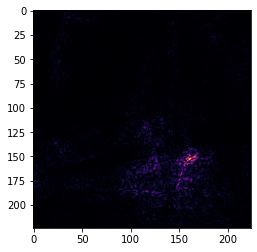

In [32]:
ig_attributions = (image - baseline) * ig
attribution_mask = tf.reduce_sum(tf.math.abs(ig_attributions), axis=-1)
plt.imshow(attribution_mask, cmap=cm.inferno)

### Putting it all together

Now you will combine the 3 previous general parts together into an `IntegratedGradients` function and utilize a [@tf.function](https://www.tensorflow.org/guide/function) decorator to compile it into a high performance callable TensorFlow graph. This is implemented as 5 smaller steps below:


$IntegratedGrads^{approx}_{i}(x)::=\overbrace{(x_{i}-x'_{i})}^\text{5.}\times \overbrace{\sum_{k=1}^{m}}^\text{4.} \frac{\partial \overbrace{F(\overbrace{x' + \overbrace{\frac{k}{m}}^\text{1.}\times(x - x'))}^\text{2.}}^\text{3.}}{\partial x_{i}} \times \overbrace{\frac{1}{m}}^\text{4.}$

1. Generate alphas $\alpha$

2. Generate interpolated images = $(x' + \frac{k}{m}\times(x - x'))$

3. Compute gradients between model $F$ output predictions with respect to input features = $\frac{\partial F(\text{interpolated path inputs})}{\partial x_{i}}$

4. Integral approximation through averaging gradients = $\sum_{k=1}^m \text{gradients} \times \frac{1}{m}$

5. Scale integrated gradients with respect to original image = $(x_{i}-x'_{i}) \times \text{integrated gradients}$. The reason this step is necessary is to make sure that the attribution values accumulated across multiple interpolated images are in the same units and faithfully represent the pixel importances on the original image.

In [33]:
@tf.function
def integrated_gradients(baseline,
                         image,
                         target_class_idx,
                         m_steps=50,
                         batch_size=32):
    # 1. Generate alphas.
    alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

    # Initialize TensorArray outside loop to collect gradients.    
    gradient_batches = tf.TensorArray(tf.float32, size=m_steps+1)
    
    # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
    for alpha in tf.range(0, len(alphas), batch_size):
        from_ = alpha
        to = tf.minimum(from_ + batch_size, len(alphas))
        alpha_batch = alphas[from_:to]

        # 2. Generate interpolated inputs between baseline and input.
        interpolated_path_input_batch = interpolate_images(baseline=baseline,
                                                           image=image,
                                                           alphas=alpha_batch)

        # 3. Compute gradients between model outputs and interpolated inputs.
        inputs = preprocess_input(interpolated_path_input_batch)
        gradient_batch = compute_gradients(images=inputs,
                                           target_class_idx=target_class_idx)
        
        # Write batch indices and gradients to extend TensorArray.
        gradient_batches = gradient_batches.scatter(tf.range(from_, to), gradient_batch)    
  
    # Stack path gradients together row-wise into single tensor.
    total_gradients = gradient_batches.stack()

    # 4. Integral approximation through averaging gradients.
    avg_gradients = integral_approximation(gradients=total_gradients)

    # 5. Scale integrated gradients with respect to input. 
    integrated_gradients = (image - baseline) * avg_gradients

    return integrated_gradients

In [34]:
ig_attributions = integrated_gradients(baseline=baseline,
                                       image=image,
                                       target_class_idx=554,
                                       m_steps=240)

attribution_mask = tf.reduce_sum(tf.math.abs(ig_attributions), axis=-1)

In [35]:
print(attribution_mask.shape)

(224, 224)


### Visualize attributions

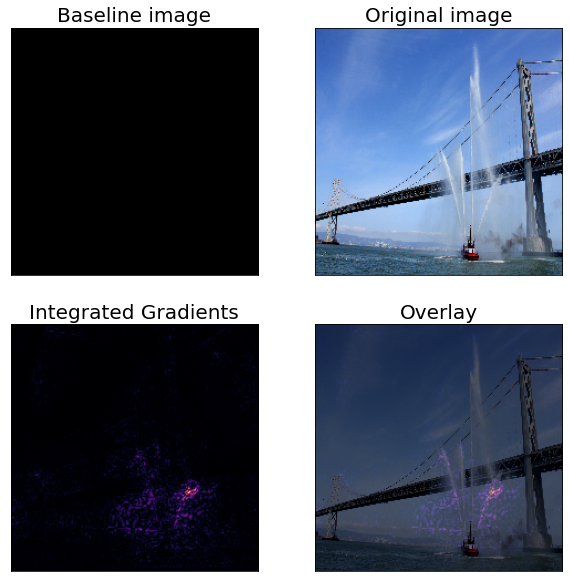

In [36]:
fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(10, 10),
                        subplot_kw={'xticks':[], 'yticks':[]})

axs[0, 0].set_title('Baseline image', fontsize=20)
axs[0, 0].imshow(baseline)

axs[0, 1].set_title('Original image', fontsize=20)
axs[0, 1].imshow(image/255)

axs[1, 0].set_title('Integrated Gradients', fontsize=20)
axs[1, 0].imshow(attribution_mask, cmap=cm.inferno)

axs[1, 1].set_title('Overlay', fontsize=20)
axs[1, 1].imshow(attribution_mask, cmap=cm.inferno)
axs[1, 1].imshow(image/255, alpha=0.4)

## 練習時間：
### 1. 自己更改 num sample 練習看看
### 2. 換張影像使用這些方法看看